### Visualization Performance


In [1]:
import numpy as np
from envs import TradingEnv
from agent import DQNAgent
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdate
import matplotlib.dates as mdates
from utils import get_data, maybe_make_dir, plot_all,buy_and_hold_benchmark 

In [2]:
test_weight = {
    'dnn':'All_2015_2020_dnn-202208050047-ep8',
    'conv1d':'All_2015_2020_conv1d-202208070118-ep20',
    'lstm':'All_2015_2020_lstm-202208060120-ep6',
}


In [3]:
stock_name = 'All_2021'
stock_table = f"{stock_name.split('_')[0]}_table"
initial_invest = 100000
slide = 20
data = get_data(stock_name, stock_table)
model_metric = {}

In [4]:
%%time
for model, weight in test_weight.items():
    # env = TradingEnv(train_data, args.initial_invest)
    env = TradingEnv(data, model, initial_invest, slide)
    action_size = env.action_space.n
    state_size = np.array(env.reset()).shape
    agent = DQNAgent(state_size, action_size, 'test', model)
    # scaler = get_scaler(env)

    portfolio_value = []

    # remake the env with test data
    env = TradingEnv(data, model, initial_invest, slide)
    # load trained weights
    agent.load(f'weights/{model}/{weight}.h5')
    daily_portfolio_value = []

    state = env.reset()
    action_list=[]
    for time in range(env.n_step):
        action = agent.act(state)
        action_list.append(action)
        next_state, reward, done, info = env.step(action)
        # next_state = scaler.transform([next_state])
        daily_portfolio_value.append(info['cur_val'])
        state = next_state
        if done:
            # plot_all(stock_name, model, daily_portfolio_value, env)
            # print(len(action_list),action_list)    
            portfolio_value.append(info['cur_val']) # append episode end portfolio value
            break
    model_metric[model] = daily_portfolio_value


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              11264     
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 59049)             60525225  
                                                                 
Total params: 61,586,089
Trainable params: 61,586,089
Non-trainable params: 0
_________________________________________________________________
None
1/1 [==============================] - 0s 42ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Ou

All_2021 data


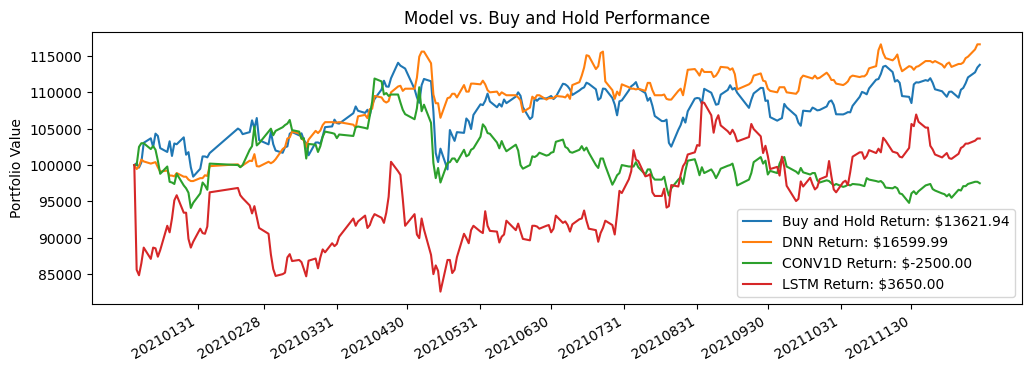

In [5]:

def plot_all_model(stock_name, model_metric, env):
    print(stock_name,'data')
    """combined plots of plot_portfolio_transaction_history and plot_portfolio_performance_comparison"""
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())

    dates, buy_and_hold_portfolio_values, buy_and_hold_return = buy_and_hold_benchmark(stock_name, env.init_invest, env.n_stock)
    ax.set_title(f'Model vs. Buy and Hold Performance')
    dates = [datetime.strptime(d, '%Y%m%d').date() for d in dates]
    ###
    dates = dates[:-1]
    buy_and_hold_portfolio_values = buy_and_hold_portfolio_values[:-1]
    # print(f'dates:     {len(dates)} \ndaily value:{len(daily_portfolio_value)}\nBH value:{len(buy_and_hold_portfolio_values)}')
    ax.plot(dates, buy_and_hold_portfolio_values, label=f'Buy and Hold Return: ${buy_and_hold_return:.2f}')
    ###
    for model, portfolio in model_metric.items():
        agent_return = portfolio[-1] - env.init_invest
        ax.plot(dates, portfolio, label=f'{model.upper()} Return: ${agent_return:.2f}')
    ax.set_ylabel('Portfolio Value')
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y%m%d'))
    # plt.xticks(pd.date_range('2018-1-02', '2019-08-22', freq='1m'))
    plt.xticks(pd.date_range(dates[0],dates[-1],freq='1m'))
    ax.legend()
    plt.gcf().autofmt_xdate()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

plot_all_model(stock_name, model_metric, env)    

In [7]:
# agent.save('test_with.h5')
# agent.save('test_without.h5')

TypeError: save_weights() got an unexpected keyword argument 'include_optimizer'